In [1]:
import os
import sys
import pyrootutils

pyrootutils.setup_root(os.path.abspath(''), indicator=".project-root", pythonpath=True)
sys.path.append('..')
sys.path.append('')


In [2]:
import itertools
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.figure import Figure
from rdkit import Chem
from torch import Tensor


Root:

In [3]:
ROOT = str(pyrootutils.find_root())
DATA_FOLDER = "data"


In [4]:
original_df = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/ames_original.csv")
df = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/ames_cleaned.csv")


In [5]:
length_original, length = len(original_df), len(df)
random_original, random = original_df["random"].value_counts().to_dict(), df["random"].value_counts().to_dict()
scaffold_original, scaffold = original_df["scaffold"].value_counts().to_dict(), df["scaffold"].value_counts().to_dict()
Y_original, y = original_df["Y"].value_counts().to_dict(), df["Y"].value_counts().to_dict()


In [6]:
print(f"Data went from {length_original} smiles to {length}.")
print(f"Random lengths went from {random_original} smiles to {random}.")
print(f"Scaffold lengths went from {scaffold_original} smiles to {scaffold}.")
print(f"Positives and negatives went from {Y_original} to {y}.")


Data went from 7278 smiles to 7247.
Random lengths went from {'train': 5094, 'test': 1456, 'valid': 728} smiles to {'train': 5071, 'test': 1451, 'valid': 725}.
Scaffold lengths went from {'train': 5094, 'test': 1457, 'valid': 727} smiles to {'train': 5074, 'test': 1452, 'valid': 721}.
Positives and negatives went from {1: 3974, 0: 3304} to {1: 3951, 0: 3296}.


# Set data to new files

In [11]:
df["Drug_ID"] = df["Drug_ID"].apply(lambda x: x.strip("Drug "))


In [12]:
for split, section in itertools.product(["random", "scaffold"], ["train", "valid", "test"]):
    df[df[split] == section].to_csv(f"{ROOT}/{DATA_FOLDER}/ames_{split}_{section}.csv")


Histogram of SMILES length

In [5]:
def plot_histograms(df: pd.DataFrame,
                    drug_column_name: Optional[str] = 'Drug',
                    label_column_name: Optional[str] = 'Y',
                    visualization_method: Optional[str] = 'dodge',
                    save_figure_path: Optional[str] = None,
                    ax: Optional[plt.Axes] = None,
                    title: Optional[str] = None,
                    ) -> Figure:
    """
    visualization_method can be "layer", "stack", "fill", "dodge"
    """

    # get lengths
    df['SMILES length'] = df[drug_column_name].apply(lambda x: len(x))

    # Rename label column
    df['Ames test result'] = df[label_column_name].map({1: 'Positive', 0: 'Negative'})

    # Initialize
    sns.set(style='whitegrid')
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Colors
    binary_palette = {'Negative': 'tab:blue', 'Positive': 'tab:orange'}

    # Sort the DataFrame so that 'Negative' is last (because of the way the plot is drawn)
    df = df.sort_values(by='Ames test result', ascending=True)

    # plot
    sns.histplot(data=df,
                 x='SMILES length',
                 hue='Ames test result',
                 multiple= visualization_method,
                 palette=binary_palette,
                 edgecolor='.3',
                 linewidth=.5,
                 ax=ax,
    )

    # save figure
    if save_figure_path is not None:
        fig.savefig(save_figure_path, format='pdf', bbox_inches='tight')

    # set title
    if title is not None:
        ax.set_title(title)

    return fig


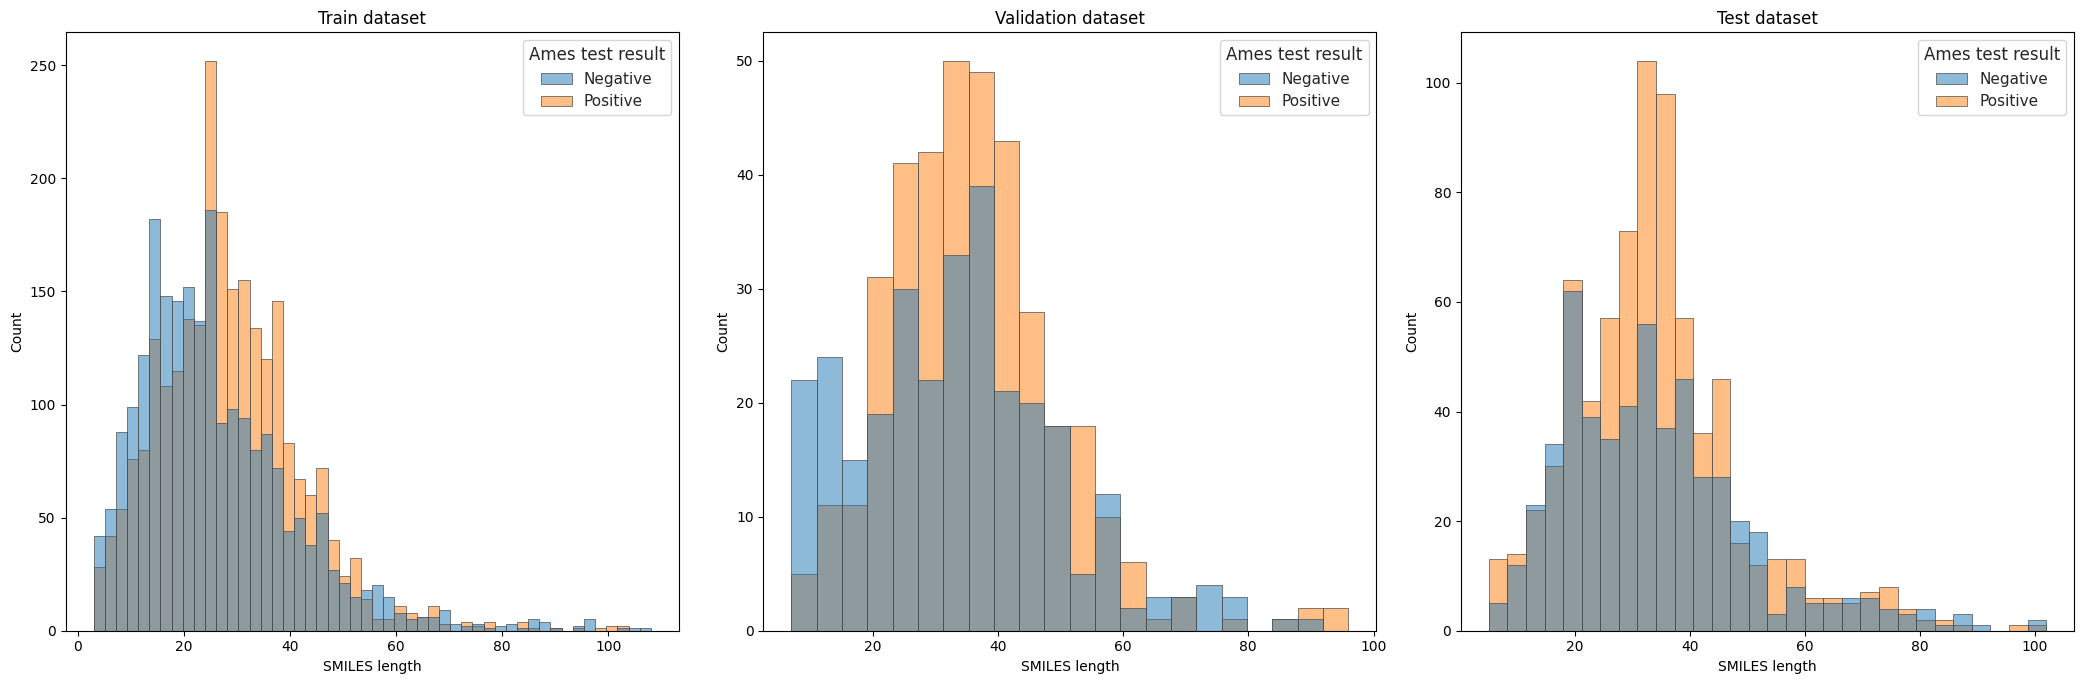

In [6]:
# Set figure size
plt.rcParams['figure.figsize'] = [21, 7]  # Width for 3 subfigures and height


fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# generate plots
plot_histograms(train_df, drug_column_name="canonical_smiles", visualization_method='layer', ax=axs[0], title='Train dataset')
plot_histograms(val_df, drug_column_name="canonical_smiles", visualization_method='layer', ax=axs[1], title='Validation dataset')
plot_histograms(test_df, drug_column_name="canonical_smiles", visualization_method='layer', ax=axs[2], title='Test dataset')

# Show
plt.tight_layout()
plt.show()

# save
# fig.savefig('Figures/composite.pdf', format='pdf', bbox_inches='tight')


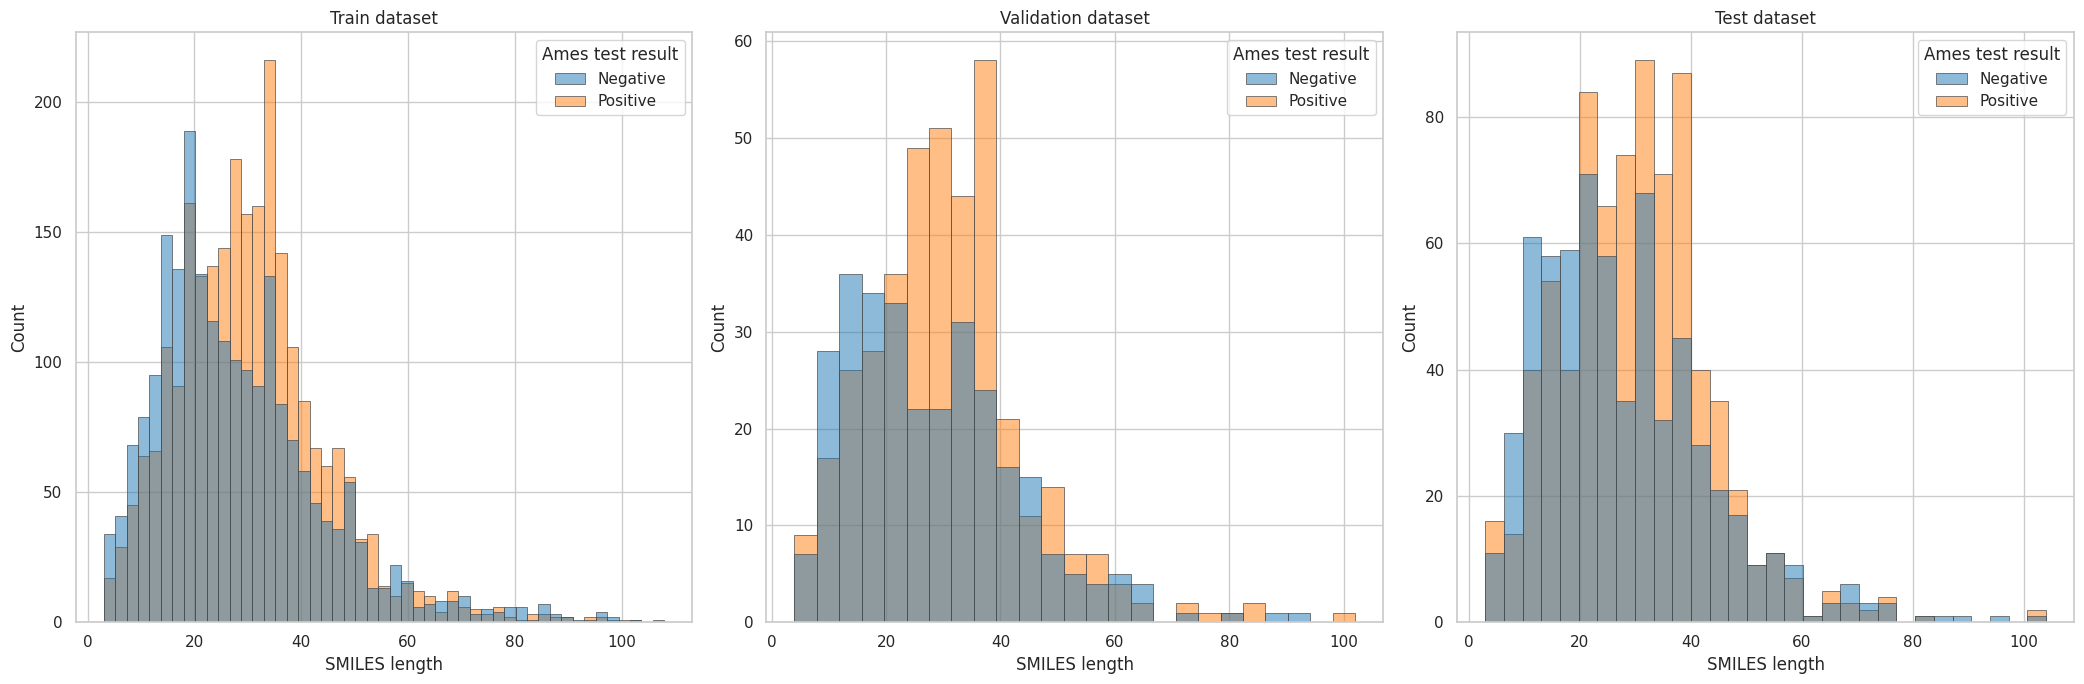

In [7]:
# Set figure size
plt.rcParams['figure.figsize'] = [21, 7]  # Width for 3 subfigures and height


fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# generate plots
plot_histograms(train_df_random, drug_column_name="canonical_smiles", visualization_method='layer', ax=axs[0], title='Train dataset')
plot_histograms(val_df_random, drug_column_name="canonical_smiles", visualization_method='layer', ax=axs[1], title='Validation dataset')
plot_histograms(test_df_random, drug_column_name="canonical_smiles", visualization_method='layer', ax=axs[2], title='Test dataset')

# Show
plt.tight_layout()
plt.show()

# save
# fig.savefig('Figures/composite.pdf', format='pdf', bbox_inches='tight')


t-SNE

In [8]:
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE


In [9]:
def get_morgan_fingerprint(smiles, radius: Optional[int] = 3, n_bits: Optional[int] = 1024):
    mol = Chem.MolFromSmiles(smiles)
    assert mol is not None, f'Could not parse SMILES: {smiles}'
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits))


In [10]:
def plot_tSNE(df: pd.DataFrame,
              drug_column_name: Optional[str] = 'Drug',
              label_column_name: Optional[str] = 'Y',
              save_figure_path: Optional[str] = None,
              ax: Optional[plt.Axes] = None,
              title: Optional[str] = None,
              ) -> Figure:

    # get fingerprints
    df['Fingerprint'] = df[drug_column_name].apply(get_morgan_fingerprint)
    fingerprint_arrays = np.array([x for x in df['Fingerprint']])

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(fingerprint_arrays)

    tsne_df = pd.DataFrame(tsne_results, columns=['t-SNE Component 1', 't-SNE Component 2'])
    tsne_df['Ames test result'] = df[label_column_name]#.map({1: 'Positive', 0: 'Negative'})

    # Initialize
    sns.set(style='whitegrid')
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Colors
    binary_palette = {'Training': 'tab:blue', 'Validation': 'tab:orange', 'Test': 'tab:red'}

    # Sort the DataFrame so that 'Negative' is last (because of the way the plot is drawn)
    tsne_df = tsne_df.sort_values(by='Ames test result', ascending=True)

    # Plotting
    sns.scatterplot(
        x='t-SNE Component 1', y='t-SNE Component 2',
        hue='Ames test result',
        palette=binary_palette,
        data=tsne_df,
        legend="full",
        alpha=0.6,
        s = 20,
        ax=ax
    )

    # Set title
    if title is not None:
        ax.set_title(title)

    # Save figure
    if save_figure_path is not None:
        fig.savefig(save_figure_path, format='pdf', bbox_inches='tight')

    return fig


In [11]:
train_df_random["section"] = "Training"
val_df_random["section"] = "Validation"
test_df_random["section"] = "Test"

train_df["section"] = "Training"
val_df["section"] = "Validation"
test_df["section"] = "Test"

full_df = pd.concat([train_df, val_df, test_df]).reset_index()
full_df_random = pd.concat([train_df_random, val_df_random, test_df_random]).reset_index()


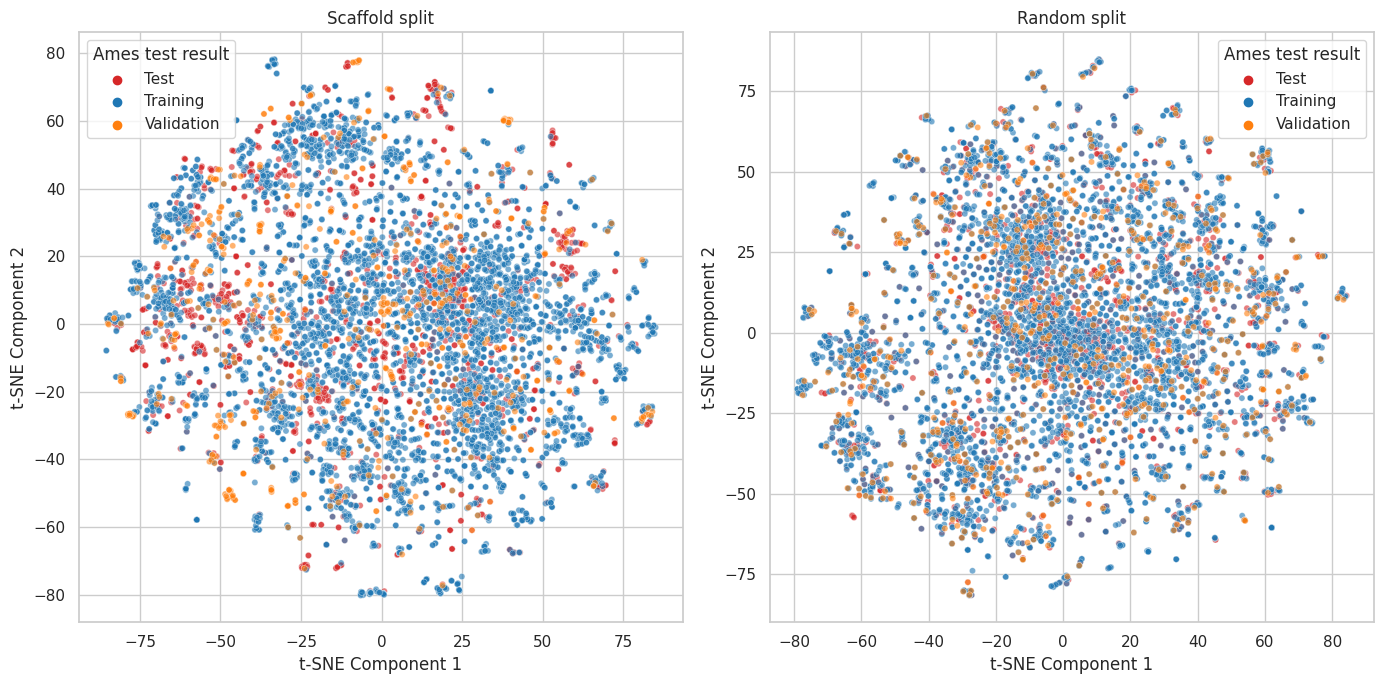

In [12]:
# Set figure size
plt.rcParams['figure.figsize'] = [14, 7]  # Width for 3 subfigures and height


fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# generate plots
plot_tSNE(full_df, drug_column_name="canonical_smiles", label_column_name="section", ax=axs[0], title='Scaffold split')
plot_tSNE(full_df_random, drug_column_name="canonical_smiles", label_column_name="section", ax=axs[1], title='Random split')

# Show
plt.tight_layout()
plt.show()

# save
# fig.savefig('Figures/tSNE.pdf', format='pdf', bbox_inches='tight')
